In [33]:
import torch, os
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")
print("MPS built:", torch.backends.mps.is_built())
print("MPS avail:", torch.backends.mps.is_available())
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using:", device)

MPS built: True
MPS avail: True
Using: mps


In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from arch.univariate import ConstantMean, GARCH, StudentsT, Normal
import matplotlib.pyplot as plt
import warnings
from collections import deque


warnings.filterwarnings("ignore")  # nuke all warnings



In [35]:

def winsorize_simple(df: pd.DataFrame, lower: float = 0.005, upper: float = 0.995, numeric_only: bool = True) -> pd.DataFrame:
    """
    Clip each (numeric) column to its [lower, upper] quantiles computed on *this* df.
    Returns a new DataFrame.
    """
    X = df.copy()
    cols = X.select_dtypes(include="number").columns if numeric_only else X.columns
    ql = X[cols].quantile(lower)
    qu = X[cols].quantile(upper)
    X[cols] = X[cols].clip(lower=ql, upper=qu, axis=1)
    return X

In [36]:
def hygiene(
    X_train,
    *,
    max_nan_pct: float = 0.50,   # drop columns with >50% NaNs on TRAIN
    numeric_only: bool = True
):
    """
    Returns:
      keep_cols : list[str]  -> columns with NaN fraction <= max_nan_pct
      report    : dict       -> quick stats of what was dropped/kept
    """
    cols = X_train.select_dtypes(include=[np.number]).columns if numeric_only else X_train.columns
    na_pct = X_train[cols].isna().mean()           # fraction of NaNs per column
    keep_cols = na_pct[na_pct <= max_nan_pct].index.tolist()
    dropped = na_pct[na_pct > max_nan_pct].sort_values(ascending=False)

    if not keep_cols:  # safety: don't return empty schema
        keep_cols = list(cols)

    report = {
        "cols_considered": int(len(cols)),
        "kept_cols": int(len(keep_cols)),
        "dropped_cols": int(dropped.size),
        "max_nan_pct": float(max_nan_pct),
        "dropped_top5": dropped.head(5).to_dict()
    }
    return keep_cols, report


In [37]:
def select_columns_for_rolling(
    X_tr: pd.DataFrame, y_tr,
    *,
    mean_windows: tuple[int, ...] = (5, 20),
    std_windows:  tuple[int, ...] = (5, 20),
    top_mean: int = 30,
    top_std:  int = 15,
    margin: float = 0.005,      # require the rolled feature to beat base corr by this much
) -> dict:
    """
    Decide which columns to build rolling MEANs / STDs for, using TRAIN ONLY.

    Strategy:
      - Baseline abs Pearson corr of each raw column with y_tr.
      - For each column, compute abs corr of rolling mean over mean_windows (INCLUDES t) with y_tr.
      - For std: use max(abs corr with y_tr, abs corr with |y_tr|) as vol->return link can be asymmetric.
      - Add a stability check (first half vs second half); score = r_all + 0.5*min(r_half1,r_half2).
      - Keep columns whose best rolling beats raw by >= margin.
      - Return top_mean by mean score, top_std by std score.

    Returns:
      {
        "mean": [(col, w), ...],
        "std":  [(col, w), ...],
        "baseline_corr": {col: abs_corr_raw, ...}
      }
    """
    X = X_tr.select_dtypes(include=[np.number]).astype("float32")
    y = np.asarray(y_tr, dtype=float).reshape(-1)
    T = len(X)
    split = max(1, int(T * 0.5))

    def _safe_corr(a, b):
        a = np.asarray(a, float); b = np.asarray(b, float)
        m = np.isfinite(a) & np.isfinite(b)
        if m.sum() < 20: return 0.0
        a = a[m] - a[m].mean(); b = b[m] - b[m].mean()
        den = np.sqrt((a*a).sum()) * np.sqrt((b*b).sum())
        return 0.0 if den == 0 else float((a*b).sum() / den)

    base_corr = {c: abs(_safe_corr(X[c], y)) for c in X.columns}

    mean_candidates = []
    for c in X.columns:
        if 'D' in c:
            continue
        best = None
        for w in mean_windows:
            r = X[c].rolling(w, min_periods=w).mean()     # includes t
            r_all = abs(_safe_corr(r, y))
            r_1   = abs(_safe_corr(r.iloc[:split], y[:split]))
            r_2   = abs(_safe_corr(r.iloc[split:], y[split:]))
            stab  = min(r_1, r_2)
            score = r_all + 0.5 * stab + 0.25 * max(0.0, r_all - base_corr[c])
            if (best is None) or (score > best[0]):
                best = (score, w, r_all)
        if best and (best[2] >= base_corr[c] + margin):
            mean_candidates.append((c, best[1], best[0], best[2]))

    std_candidates = []
    ay = np.abs(y)
    for c in X.columns:
        if 'D' in c:
            continue
        best = None
        for w in std_windows:
            s = X[c].rolling(w, min_periods=w).std(ddof=0)
            r_all = max(abs(_safe_corr(s, y)), abs(_safe_corr(s, ay)))
            r_1   = max(abs(_safe_corr(s.iloc[:split], y[:split])),
                        abs(_safe_corr(s.iloc[:split], ay[:split])))
            r_2   = max(abs(_safe_corr(s.iloc[split:], y[split:])),
                        abs(_safe_corr(s.iloc[split:], ay[split:])))
            stab  = min(r_1, r_2)
            score = r_all + 0.5 * stab
            if (best is None) or (score > best[0]):
                best = (score, w, r_all)
        if best and best[2] >= 0.01:
            std_candidates.append((c, best[1], best[0], best[2]))

    # deterministic ordering: sort by (r_all desc, score desc, col name)
    mean_sel = sorted(mean_candidates, key=lambda t: (-t[3], -t[2], t[0], t[1], t[0]))[:top_mean]
    std_sel  = sorted(std_candidates,  key=lambda t: (-t[3], -t[2], t[0], t[1], t[0]))[:top_std]

    return {
        "mean": [(c, w) for (c, w, *_rest) in mean_sel],
        "std":  [(c, w) for (c, w, *_rest) in std_sel],
        "baseline_corr": base_corr
    }

In [38]:
def build_rolling_features(
    X: pd.DataFrame,
    selection: dict,
    *,
    dtype: str = "float32"
) -> pd.DataFrame:
    """
    Build rolling features ON ANY SPLIT (train/valid/test) using a selection dict from TRAIN:
      selection = {"mean": [(col, w), ...], "std": [(col, w), ...], ...}

    Uses windows that INCLUDE row t (consistent with your comp: today's data is available).
    """
    out = X.copy()
    # MEANS
    for c, w in selection.get("mean", []):
        if c in X.columns:
            out[f"{c}_rmean{w}"] = X[c].rolling(w, min_periods=w).mean()
    # STDs
    for c, w in selection.get("std", []):
        if c in X.columns:
            out[f"{c}_rstd{w}"] = X[c].rolling(w, min_periods=w).std(ddof=0)
    return out.astype(dtype)

In [39]:
df = pd.read_csv('../train.csv')

In [40]:
df['lagged_market_forward_excess_returns'] = df['market_forward_excess_returns'].shift(1)
df['lagged_risk_free_rate'] = df['risk_free_rate'].shift(1)

In [41]:
X = df.drop(columns = ['date_id', 'market_forward_excess_returns', 'risk_free_rate', 'forward_returns'])
y = df[['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']]

In [42]:
keep_cols, report = hygiene(X, max_nan_pct = 0.2)

In [43]:
X = X[keep_cols]

In [44]:
X

,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,...,V13,V2,V3,V4,V5,V6,V7,V8,lagged_market_forward_excess_returns,lagged_risk_free_rate
0,0,0,0,1,1,0,0,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,1,1,0,0,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003038,0.000301
2,0,0,0,1,0,0,0,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009114,0.000303
3,0,0,0,1,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010243,0.000301
4,0,0,0,1,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004046,0.000299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,0,0,0,0,0,0,0,0,0,1.565379,...,-0.432282,0.785053,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,-0.003365,0.000159
8986,0,0,0,0,0,0,0,0,0,1.562946,...,-0.429506,0.767857,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,0.001990,0.000155
8987,0,0,1,0,0,0,0,0,0,1.560520,...,-0.425462,0.734127,0.481481,0.787698,0.834898,0.823413,-0.723949,0.133929,0.001845,0.000156
8988,0,0,0,0,0,0,0,0,0,1.558102,...,-0.385170,0.695106,0.655423,0.783730,0.994026,0.851852,-0.684937,0.101852,0.002424,0.000156


In [45]:
y

,forward_returns,risk_free_rate,market_forward_excess_returns
0,-0.002421,0.000301,-0.003038
1,-0.008495,0.000303,-0.009114
2,-0.009624,0.000301,-0.010243
3,0.004662,0.000299,0.004046
4,-0.011686,0.000299,-0.012301
...,...,...,...
8985,0.002457,0.000155,0.001990
8986,0.002312,0.000156,0.001845
8987,0.002891,0.000156,0.002424
8988,0.008310,0.000156,0.007843


In [46]:
rolling_window_col = select_columns_for_rolling(X, y['market_forward_excess_returns'])

In [47]:
X_roll = build_rolling_features(X, rolling_window_col)

In [48]:
X_roll = X_roll.ffill().dropna(inplace=False)
y = y.iloc[X_roll.index]

In [49]:
X_roll

,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,...,M11_rstd5,E19_rstd20,V7_rstd5,E2_rstd20,P6_rstd20,P10_rstd20,S5_rstd20,P2_rstd20,P7_rstd20,I2_rstd5
1784,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.337132,...,0.050174,1.074546,0.236620,0.123967,0.204241,0.020379,0.350449,0.082911,0.831126,0.030294
1785,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,2.331770,...,0.051502,1.069196,0.315206,0.137084,0.171930,0.022159,0.312050,0.087002,0.816376,0.024469
1786,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,2.326440,...,0.046554,1.059211,0.222685,0.140102,0.152714,0.022932,0.301208,0.088142,0.840449,0.004756
1787,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,2.321140,...,0.069871,1.190460,0.289053,0.140330,0.152684,0.023440,0.294661,0.086366,0.924996,0.006400
1788,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,2.315869,...,0.096579,1.161157,0.415330,0.140654,0.155371,0.025124,0.290222,0.086279,0.983902,0.038660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.565379,...,0.038660,0.239573,0.096425,0.048044,0.134049,0.015866,0.169989,0.033179,0.894056,0.039348
8986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.562946,...,0.038351,0.242880,0.101001,0.048078,0.125739,0.015783,0.164506,0.032184,0.898318,0.062131
8987,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.560520,...,0.042348,0.249010,0.060203,0.047299,0.107747,0.015799,0.160674,0.030049,0.899357,0.086269
8988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.558102,...,0.049266,0.249145,0.014380,0.049632,0.080407,0.015471,0.152722,0.029744,0.842694,0.067153


In [50]:
rolling_window_col

{'mean': [('lagged_market_forward_excess_returns', 5),
  ('S5', 20),
  ('E18', 20),
  ('P13', 20),
  ('P6', 20),
  ('V5', 20),
  ('S11', 20),
  ('E14', 20)],
 'std': [('lagged_market_forward_excess_returns', 20),
  ('V13', 5),
  ('M4', 20),
  ('P8', 20),
  ('P11', 20),
  ('M11', 5),
  ('E19', 20),
  ('V7', 5),
  ('E2', 20),
  ('P6', 20),
  ('P10', 20),
  ('S5', 20),
  ('P2', 20),
  ('P7', 20),
  ('I2', 5)],
 'baseline_corr': {'D1': 0.03418545560638734,
  'D2': 0.03418545560638734,
  'D3': 0.0059881670528166885,
  'D4': 0.016628805374216793,
  'D5': 0.016601855820272644,
  'D6': 0.016915601936684274,
  'D7': 0.010706466222193987,
  'D8': 0.02468685410358544,
  'D9': 0.0010799981921349139,
  'E1': 0.007076290315951063,
  'E10': 0.0026045134765044172,
  'E11': 0.03204031785220333,
  'E12': 0.030842726463354207,
  'E13': 0.009725975744005206,
  'E14': 0.001181124379148817,
  'E15': 0.005156395892332831,
  'E16': 0.006175100672811253,
  'E17': 0.0065420675482403615,
  'E18': 0.0081758499931

In [51]:
X_test = X_roll[-1000:]
X_val = X_roll[-2000:-1000]
X_train = X_roll[:-2000]
y_test = y[-1000:]
y_val = y[-2000:-1000]
y_train = y[:-2000]

In [52]:
import random, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")


'1'

In [53]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
def set_seeds(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [55]:
def fit_imputer_scaler(X_tr: np.ndarray):
    # X_tr: [T,F] float32
    med = np.nanmedian(X_tr, axis=0)        # robust to outliers
    X0  = np.where(np.isfinite(X_tr), X_tr, med)  # impute NaNs/inf with medians
    mu  = X0.mean(axis=0)
    sd  = X0.std(axis=0, ddof=0); sd[sd==0] = 1.0
    return med.astype("float32"), mu.astype("float32"), sd.astype("float32")

In [56]:
def apply_imputer_scaler(X: np.ndarray, med: np.ndarray, mu: np.ndarray, sd: np.ndarray):
    X = np.where(np.isfinite(X), X, med)
    X = (X - mu) / sd
    return X.astype("float32")

In [57]:
class WindowedTSDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int):
        """
        X: [T, F] standardized, y: [T]
        For each t >= seq_len-1, sample = X[t-seq_len+1 : t] (inclusive), label = y[t]
        """
        #print(X.ndim, y.ndim, len(X), len(y))
        assert X.ndim == 2 and y.ndim == 1 and len(X) == len(y)
        self.X = X.astype("float32", copy=False)
        self.y = y.astype("float32", copy=False)
        self.L = int(seq_len)
        self.first = self.L - 1
        self.last  = len(self.X) - 1

    def __len__(self):
        return max(0, self.last - self.first + 1)

    def __getitem__(self, i):
        t = self.first + i
        x = self.X[t-self.L+1 : t+1]     # [L, F]
        y = self.y[t]                    # scalar
        return torch.from_numpy(x), torch.tensor(y)

In [58]:
class TinyTimeTransformer(nn.Module):
    def __init__(self, n_features, seq_len=64, d_model=64, n_heads=4, n_layers=2, d_ff=128, dropout=0.2):
        super().__init__()
        self.in_proj = nn.Linear(n_features, d_model)
        self.pos = nn.Parameter(torch.zeros(1, seq_len, d_model))  # learned positional embeddings
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, batch_first=True, activation="gelu", norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, 1)
        )

    def forward(self, x):  # x: [B, L, F]
        B, L, _ = x.shape
        h = self.in_proj(x) + self.pos[:, :L, :]
        h = self.encoder(h)          # [B, L, d]
        h_last = h[:, -1, :]         # take last token
        out = self.head(h_last).squeeze(-1)  # [B]
        return out


In [59]:
@torch.no_grad()
def pearson_corr_torch(pred, y, eps=1e-8):
    pred = pred.view(-1); y = y.view(-1)
    pred = pred - pred.mean()
    y    = y - y.mean()
    pred_std = pred.pow(2).mean().sqrt().clamp_min(eps)
    y_std    = y.pow(2).mean().sqrt().clamp_min(eps)
    corr = (pred / pred_std * y / y_std).mean()
    return torch.nan_to_num(corr, nan=0.0)

def loss_mse_plus_corr(pred, y, alpha_corr=0.1):
    mse  = F.mse_loss(pred, y)
    corr = pearson_corr_torch(pred, y)
    loss = mse + alpha_corr * (1.0 - corr)
    return torch.nan_to_num(loss, nan=1e6, posinf=1e6, neginf=1e6), mse, corr

In [60]:
def train_transformer(
    X_tr, y_tr, X_va, y_va,
    seq_len=64, batch_size=64, epochs=200, lr=3e-4, wd=1e-4,
    alpha_corr=0.1, patience=12, seed=42, device=None,
    model_kwargs=None
):
    set_seeds(seed)
    device = device or get_device()
    model_kwargs = dict(d_model=64, n_heads=4, n_layers=2, d_ff=128, dropout=0.2) | (model_kwargs or {})
    # fit imputer+scaler on TRAIN only, apply to both
    med, mu, sd = fit_imputer_scaler(X_tr)
    X_tr_z = apply_imputer_scaler(X_tr, med, mu, sd)
    X_va_z = apply_imputer_scaler(X_va, med, mu, sd)
    # datasets/loaders
    ds_tr = WindowedTSDataset(X_tr_z, y_tr, seq_len)
    ds_va = WindowedTSDataset(X_va_z, y_va, seq_len)
    if len(ds_tr) == 0 or len(ds_va) == 0:
        raise ValueError("Not enough rows after windowing; reduce seq_len or ensure features are filled.")
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)
    dl_va = DataLoader(ds_va, batch_size=256, shuffle=False, num_workers=0)
    # model/opt
    model = TinyTimeTransformer(n_features=X_tr.shape[1], seq_len=seq_len, **model_kwargs).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    best = {"corr": -1e9, "state": None, "epoch": -1}
    no_improve = 0
    print(len(dl_tr))
    xb0, yb0 = next(iter(dl_tr))
    print("xb0 finite?", torch.isfinite(xb0).all().item(),
      "yb0 finite?", torch.isfinite(yb0).all().item())

    for epoch in range(epochs):
        model.train()
        i = 0
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss, mse, corr = loss_mse_plus_corr(pred, yb, alpha_corr=alpha_corr)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            print(i, loss, mse, corr)
            i+=1
        
        # validation
        model.eval()
        preds, targs = [], []
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(device)
                preds.append(model(xb).cpu()); targs.append(yb)
        yhat = torch.cat(preds); yt = torch.cat(targs)
        corr_va = float(pearson_corr_torch(yhat, yt))
        mse_va  = float(F.mse_loss(yhat, yt))

        if corr_va > best["corr"] + 1e-4:
            best = {"corr": corr_va, "state": model.state_dict(), "epoch": epoch}
            no_improve = 0
        else:
            no_improve += 1
        # print(f"epoch {epoch:03d}  val_corr={corr_va:.4f}  val_mse={mse_va:.6e}")

        if no_improve >= patience:
            break

    model.load_state_dict(best["state"])
    model.eval()
    artifacts = {
        "val_best_corr": best["corr"],
        "val_best_epoch": best["epoch"],
        "med": med, "mu": mu, "sd": sd,
        "seq_len": seq_len,
        "model_kwargs": model_kwargs
    }
    return model, artifacts

In [61]:
@torch.no_grad()
def predict_seq(X, y, model, artifacts, device=None, batch_size=256):
    """
    Predict for a whole split using the same windowing (ends-at-t -> y_t).
    Returns (yhat_np, y_aligned_np)
    """
    device = device or get_device()
    med, mu, sd = artifacts["med"], artifacts["mu"], artifacts["sd"]
    L = artifacts["seq_len"]
    Xz = apply_imputer_scaler(X, med, mu, sd)
    ds  = WindowedTSDataset(Xz, y, L)
    dl  = DataLoader(ds, batch_size=batch_size, shuffle=False)
    model = model.to(device).eval()

    preds, targs = [], []
    for xb, yb in dl:
        preds.append(model(xb.to(device)).cpu().numpy())
        targs.append(yb.numpy())
    yhat = np.concatenate(preds, axis=0)
    yt   = np.concatenate(targs, axis=0)
    return yhat, yt

In [62]:
def pearson_np(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a - a.mean(); b = b - b.mean()
    den = np.sqrt((a*a).sum()) * np.sqrt((b*b).sum())
    return 0.0 if den == 0 else float((a*b).sum()/den)

def hit_rate_np(y, yhat):
    return float((np.sign(y) == np.sign(yhat)).mean())

In [202]:
Xtr = X_train.to_numpy(dtype=np.float32)
Xva = X_val.to_numpy(dtype=np.float32)
Xeva = X_test.to_numpy(dtype=np.float32)
ytr = y_train['market_forward_excess_returns'].to_numpy(dtype=np.float32)
yva = y_val['market_forward_excess_returns'].to_numpy(dtype=np.float32)
yeva = y_test['market_forward_excess_returns'].to_numpy(dtype=np.float32)

In [64]:
device = get_device()
model, arts = train_transformer(
    Xtr, ytr, Xva, yva,
    seq_len=64, batch_size=64, epochs=200,
    lr=3e-4, wd=1e-4, alpha_corr=0.1, patience=12,
    seed=42, device=device,
    model_kwargs=dict(d_model=48, n_heads=4, n_layers=2, d_ff=96, dropout=0.3)
)

80
xb0 finite? True yb0 finite? True
0 tensor(0.2535, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.1387, device='mps:0', grad_fn=<MseLossBackward0>) tensor(-0.1484, device='mps:0')
1 tensor(0.2168, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.1137, device='mps:0', grad_fn=<MseLossBackward0>) tensor(-0.0311, device='mps:0')
2 tensor(0.3191, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.2020, device='mps:0', grad_fn=<MseLossBackward0>) tensor(-0.1709, device='mps:0')
3 tensor(0.1662, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.0688, device='mps:0', grad_fn=<MseLossBackward0>) tensor(0.0253, device='mps:0')
4 tensor(0.1851, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.0730, device='mps:0', grad_fn=<MseLossBackward0>) tensor(-0.1212, device='mps:0')
5 tensor(0.1246, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.0290, device='mps:0', grad_fn=<MseLossBackward0>) tensor(0.0432, device='mps:0')
6 tensor(0.1308, device='mps:0', grad_fn=<NanTo

In [ ]:
yhat_va, y_aligned_va = predict_seq(Xva, yva, model, arts, device=device)
print("Val Pearson:", pearson_np(y_aligned_va, yhat_va))
print("Val HitRate:", hit_rate_np(y_aligned_va, yhat_va))

Val Pearson: 0.07149680703878403
Val HitRate: 0.5400213447171825


In [94]:
len(y_aligned_va)

937

In [66]:
yhat_tr

array([0.00092412, 0.00233037, 0.00267992, ..., 0.00086848, 0.00105703,
       0.00072113], dtype=float32)

In [67]:
def feature_selection(X_tr, y_tr, X_va, y_va, *, k=30, top_corr=60,
                     use_extratrees=True, val_last=252, n_repeats=5, seed=42, w_corr=0.6, w_perm=0.4):
    # 1) keep a small validation slice
    if val_last is not None and len(X_va) > val_last:
        Xv = X_va.iloc[-val_last:].astype(np.float32).copy()
        yv = y_va.iloc[-val_last:].to_numpy()
    else:
        Xv = X_va.astype(np.float32).copy()
        yv = y_va.to_numpy()

    # 2) univariate Pearson on TRAIN; take top N
    corr_abs = X_tr.apply(lambda c: np.corrcoef(c, y_tr)[0,1], axis=0).abs().fillna(0.0)
    cand = corr_abs.sort_values(ascending=False).head(min(top_corr, X_tr.shape[1])).index.tolist()

    # 3) small, fast tree on TRAIN
    Tree = ExtraTreesRegressor if use_extratrees else RandomForestRegressor
    tree = Tree(
        n_estimators=100, max_depth=8, min_samples_leaf=0.01, max_features=0.7,
        n_jobs=-1, random_state=seed
    ).fit(X_tr[cand].astype(np.float32), y_tr.to_numpy())

    # 4) permutation importance on VALID (few repeats, parallel)
    pi = permutation_importance(tree, Xv[cand], yv, n_repeats=n_repeats,
                                random_state=seed, scoring="neg_mean_squared_error", n_jobs=-1)
    perm = pd.Series(pi.importances_mean, index=cand)

    # 5) combine by rank (robust to scaling)
    r_corr = corr_abs.loc[cand].rank(ascending=False)
    r_perm = perm.rank(ascending=False)
    score = (w_corr * r_corr + w_perm * r_perm).sort_values(ascending=False)

    selected = score.index[:min(k, len(score))].tolist()
    summary = pd.DataFrame({"corr_abs": corr_abs.loc[cand], "perm": perm, "score_rank": score}).loc[score.index]
    return selected, summary

In [68]:
def logistic_train(X_train, y_train, features = None, C=1.0):
    """
    Train a Logistic regression model and evaluate on validation set.

    Parameters
    ----------
    X_train : pd.DataFrame
        Training features.
    y_train : pd.Series
        Training target.
   
    C : float, default 1.0
        Inverse of regularization strength for Logistic regression.

    Returns
    -------
    model : LogisticRegression
        Trained Logistic regression model.
    
    """
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(penalty = "l2", solver = 'lbfgs', C=C, max_iter=2000))
    ])

    if features:
        model.fit(X_train[features], y_train)
    else:
        model.fit(X_train, y_train)

    return model

In [172]:
def trees_train(X_train, y_train, features = None, type='RandomForest'):
    """
    Train a Tree Regressor and evaluate on validation set.

    Parameters
    ----------
    X_train : pd.DataFrame
        Training features.
    y_train : pd.Series
        Training target.
   
    n_estimators : int, default 100
        Number of trees in the forest.
    
    max_depth : int or None, default None
        Maximum depth of the tree.

    random_state : int, default 42
        Random seed for reproducibility.

    Returns
    -------
    model : Regressor
    
    """
    
    if type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=1000,
            max_depth=6,
            min_samples_leaf=0.03,     # 3% of samples per leaf (robust)
            min_samples_split=0.02,
            max_features=0.3,
            bootstrap=True,
            n_jobs=-1, random_state=42)
        
    elif type == 'ExtraTrees':
        model = ExtraTreesRegressor(
            n_estimators=600,
            max_depth=8,
            min_samples_leaf=0.01,
            min_samples_split=0.02,
            max_features=0.7,
            bootstrap=False,
            n_jobs=-1, random_state=42
        )

    elif type == 'XGBoost':
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.10,
            max_depth=4,
            subsample=0.7,
            colsample_bytree=0.7,
            min_child_weight=10,       # combats noise
            reg_lambda=2.0,
            objective="reg:squarederror",
            n_jobs=-1, random_state=42
        )
    elif type == 'LightGBM':
        model = LGBMRegressor(
            verbosity = -1,
            n_estimators=800,
            learning_rate=0.01,
            max_depth=6,
            num_leaves=31,             # <= 2^max_depth for safety
            min_data_in_leaf=150,      # robust on small-signal data
            feature_fraction=0.9,
            bagging_fraction=0.7,
            bagging_freq=1,
            lambda_l2=20.0,
            extra_trees=True,          # adds randomness like ExtraTrees
            n_jobs=-1, random_state=42,
            min_gain_to_split=1e-3
        )
    if features:
        model.fit(X_train[features], y_train)
    else:
        model.fit(X_train, y_train)

    return model

In [76]:
X_trainp = pd.read_csv('X_train.csv')
y_trainp = pd.read_csv('y_train.csv')['market_forward_excess_returns']

In [77]:
X_features = X_trainp[-500:]
X_trainp = X_trainp[:-500]
y_features = y_trainp[-500:]
y_trainp = y_trainp[:-500]

In [102]:
X_valp = pd.read_csv('X_val.csv').iloc[-937:]
y_valp = pd.read_csv('y_val.csv')['market_forward_excess_returns'].iloc[-937:]

In [141]:
normalised_features = [x for x in X_trainp.columns if 'z' in x]
regression_features, regression_feature_summary = feature_selection(X_trainp[normalised_features], y_trainp, X_features[normalised_features], y_features, w_corr=0.95, w_perm=0.05, k = 40, top_corr=250)

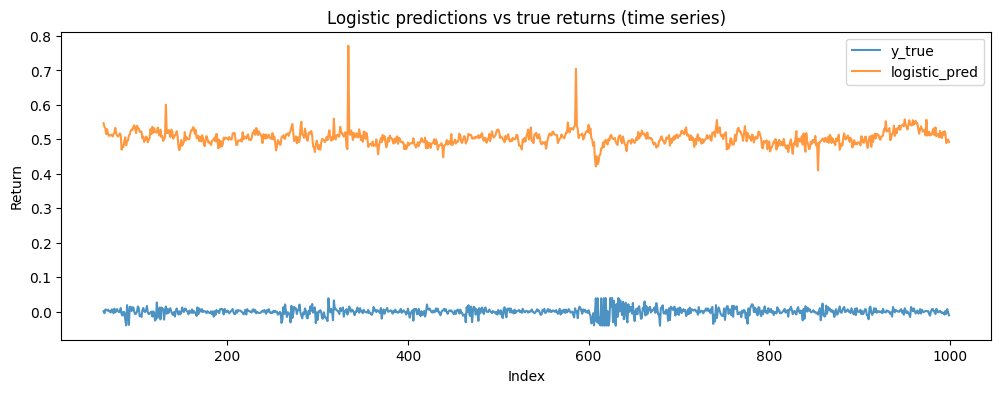

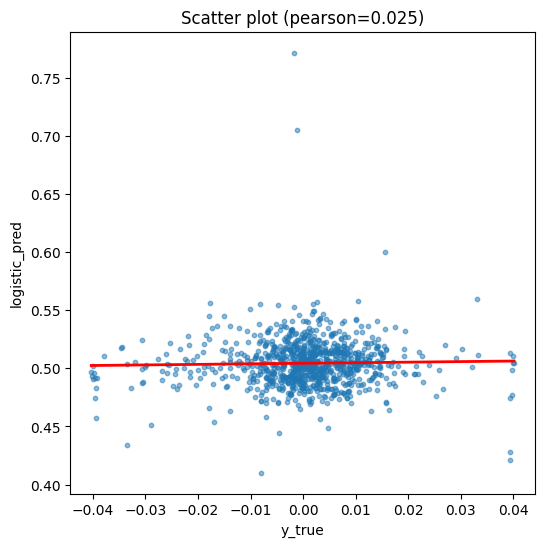

Pearson correlation: 0.025096970091153418
Hit rate: 0.544290288153682


In [187]:
# plot ensemble_eval vs y_eval (time series + scatter)
e = np.asarray(logistic_predict_val).flatten()
y = np.asarray(y_valp).flatten()

n = min(len(e), len(y))
e = e[:n]
y = y[:n]

# try to keep original index if available
idx = getattr(y_valp, "index", None)
if idx is None or len(idx) < n:
    idx = range(n)
else:
    idx = idx[:n]

s_ens = pd.Series(e, index=idx, name="logistic_pred")
s_y = pd.Series(y, index=idx, name="y_true")

plt.figure(figsize=(12, 4))
plt.plot(s_y, label="y_true", alpha=0.8)
plt.plot(s_ens, label="logistic_pred", alpha=0.8)
plt.legend()
plt.title("Logistic predictions vs true returns (time series)")
plt.xlabel("Index")
plt.ylabel("Return")
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(s_y, s_ens, s=10, alpha=0.5)
m, b = np.polyfit(s_y, s_ens, 1)
xs = np.linspace(s_y.min(), s_y.max(), 100)
plt.plot(xs, m * xs + b, color="red", lw=2)
plt.xlabel("y_true")
plt.ylabel("logistic_pred")
plt.title(f"Scatter plot (pearson={pearson_np(s_y, s_ens):.3f})")
plt.show()

print("Pearson correlation:", pearson_np(s_y, s_ens))
print("Hit rate:", hit_rate_np(s_y, s_ens))

In [182]:
logistic_y = [1 if x > 0 else 0 for x in list(np.asarray(y_trainp).flatten())]
logistic = logistic_train(X_trainp, pd.Series(logistic_y), features = regression_features, C=0.2)
logistic_predict_val = logistic.predict_proba(X_valp[regression_features])[:, 1]
logistic_hit_rate = hit_rate_np(y_valp, logistic_predict_val)
logistic_pearson = pearson_np(y_valp, logistic_predict_val)
print("Logistic Hit Rate:", logistic_hit_rate, "Pearson Correlation:", logistic_pearson)


Logistic Hit Rate: 0.544290288153682 Pearson Correlation: 0.025096970091153418


In [189]:
btree_features, btree_feature_summary = feature_selection(X_trainp.drop(columns = normalised_features, inplace = False), y_trainp, X_features.drop(columns = normalised_features, inplace = False), y_features, w_corr=0.6, w_perm=0.4, k = 450, top_corr=500)

In [190]:
lightgbm = trees_train(X_trainp, y_trainp, features=sorted(btree_features), type='LightGBM')
lightgbm_predict_val = lightgbm.predict(X_valp[sorted(btree_features)])
lightgbm_hit_rate = hit_rate_np(y_valp, lightgbm_predict_val)
lightgbm_pearson = pearson_np(y_valp, lightgbm_predict_val)
print("LightGBM Hit Rate:", lightgbm_hit_rate, "Pearson Correlation:", lightgbm_pearson)   


LightGBM Hit Rate: 0.5112059765208111 Pearson Correlation: 0.02905985624705702


In [192]:
tree_features, tree_feature_summary = feature_selection(X_trainp.drop(columns = normalised_features, inplace = False), y_trainp, X_features.drop(columns = normalised_features, inplace = False), y_features, w_corr=0.6, w_perm=0.4, k = 270, top_corr=300)

In [193]:
rf = trees_train(X_trainp, y_trainp, features=sorted(tree_features), type='RandomForest')
rf_predict_val = rf.predict(X_valp[sorted(tree_features)]) 
rf_hit_rate = hit_rate_np(y_valp, rf_predict_val)
rf_pearson = pearson_np(y_valp, rf_predict_val)
print("Random Forest Hit Rate:", rf_hit_rate, "Pearson Correlation:", rf_pearson)

Random Forest Hit Rate: 0.4994663820704376 Pearson Correlation: 0.028352796005507563


In [196]:
transformer_hit_rate = hit_rate_np(y_valp, yhat_va)
transformer_pearson = pearson_np(y_valp, yhat_va)
print("Ensemble Hit Rate:", transformer_hit_rate, "Pearson Correlation:", transformer_pearson)

Ensemble Hit Rate: 0.5400213447171825 Pearson Correlation: 0.07149680267197107


In [199]:
ensemble_val = (0.8*yhat_va+0 * logistic_predict_val + 0.1 * lightgbm_predict_val + 0.1 * rf_predict_val)
essemble_hit_rate = hit_rate_np(y_valp, ensemble_val)
ensemble_pearson = pearson_np(y_valp, ensemble_val)
print("Ensemble Hit Rate:", essemble_hit_rate, "Pearson Correlation:", ensemble_pearson)

Ensemble Hit Rate: 0.5346851654215582 Pearson Correlation: 0.07171514457756177


In [200]:
X_evalp = pd.read_csv('X_test.csv').iloc[-937:]
y_evalp = pd.read_csv('y_test.csv')['market_forward_excess_returns'].iloc[-937:]

In [203]:
yhat_eva, y_aligned_eva = predict_seq(Xeva, yeva, model, arts, device=device)
print("Val Pearson:", pearson_np(y_aligned_va, yhat_va))
print("Val HitRate:", hit_rate_np(y_aligned_va, yhat_va))

Val Pearson: 0.07149680703878403
Val HitRate: 0.5400213447171825
